In [20]:
!pip install pytorch-lightning --upgrade
!pip install lightning-bolts --upgrade

     |████████████████████████████████| 316 kB 30 kB/s eta 0:00:01


In [30]:
import torch
import torchaudio, torchvision
import os
import matplotlib.pyplot as plt 
import librosa
import argparse 
import pytorch_lightning as pl

In [35]:
class KWSDataModule(pl.LightningDataModule):
    def __init__(self, path, batch_size=128, num_workers=0, n_fft=512, 
                 n_mels=128, win_length=None, hop_length=256, **kwargs):
        super().__init__(**kwargs)
        self.path = path
        self.batch_size = batch_size
        self.num_workers = num_workers
        self.n_fft = n_fft
        self.n_mels = n_mels
        self.win_length = win_length
        self.hop_length = hop_length

    def prepare_data(self):
        self.train_dataset = torchaudio.datasets.SPEECHCOMMANDS(self.path,
                                                                download=True,
                                                                subset='training')
        self.val_dataset = torchaudio.datasets.SPEECHCOMMANDS(self.path,
                                                              download=True,
                                                              subset='validation')
        self.test_dataset = torchaudio.datasets.SPEECHCOMMANDS(self.path,
                                                               download=True,
                                                               subset='testing')

        _, sample_rate, _, _, _ = self.train_dataset[0]
        self.transform = torchaudio.transforms.MelSpectrogram(sample_rate=sample_rate,
                                                              n_fft=self.n_fft,
                                                              win_length=self.win_length,
                                                              hop_length=self.hop_length,
                                                              n_mels=self.n_mels,
                                                              power=2.0)


    def setup(self, stage=None):
        self.prepare_data()

    def train_dataloader(self):
        return torch.utils.data.DataLoader(
            self.train_dataset,
            batch_size=self.batch_size,
            num_workers=self.num_workers,
            shuffle=True,
            pin_memory=True,
            transform=self.transform,
        )

    def val_dataloader(self):
        return torch.utils.data.DataLoader(
            self.val_dataset,
            batch_size=self.batch_size,
            num_workers=self.num_workers,
            shuffle=False,
            pin_memory=True,
            transform=self.transform,
        )
    
    def test_dataloader(self):
        return torch.utils.data.DataLoader(
            self.test_dataset,
            batch_size=self.batch_size,
            num_workers=self.num_workers,
            shuffle=False,
            pin_memory=True,
            transform=self.transform,
        )

In [36]:
class KWSModel(pl.LightningModule):
    def __init__(self, num_classes=36, epochs=30, device=torch.device('cpu'), **kwargs):
        super().__init__()
        self.save_hyperparameters()
        self.model = torchvision.models.resnet18(pretrained=True)
        self.model.fc = torch.nn.Linear(512, num_classes)
        self.model.to(self.hparams.device)

    def forward(self, x):
        return self.model(x)

    def training_step(self, batch, batch_idx):
        inputs, labels = batch
        #inputs = inputs.to(self.hparams.device)
        #labels = labels.to(self.hparams.device)
        outputs = self.model(inputs)
        loss = self.hparams.criterion(outputs, labels)
        return {'loss': loss}

    def validation_step(self, batch, batch_idx):
        inputs, labels = batch
        #inputs = inputs.to(self.hparams.device)
        #labels = labels.to(self.hparams.device)
        outputs = self.model(inputs)
        loss = self.hparams.criterion(outputs, labels)
        return {'val_loss': loss}

    def test_step(self, batch, batch_idx):
        inputs, labels = batch
        #inputs = inputs.to(self.hparams.device)
        #labels = labels.to(self.hparams.device)
        outputs = self.model(inputs)
        loss = self.hparams.criterion(outputs, labels)
        return {'test_loss': loss}

    def validation_epoch_end(self, outputs):
        avg_loss = torch.stack([x['val_loss'] for x in outputs]).mean()
        avg_accuracy = torch.stack([x['accuracy'] for x in outputs]).mean()
        tensorboard_logs = {'val_loss': avg_loss, 'val_accuracy': avg_accuracy}
        return {'val_loss': avg_loss, 'log': tensorboard_logs}

    def configure_optimizers(self):
        optimizer = torch.optim.AdamW(
            self.parameters(), lr=self.hparams.args.learning_rate)
        lr_scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer=optimizer,T_max=self.hparams.epochs)
        return [optimizer], [lr_scheduler]

    def setup(self, stage=None):
        self.hparams.criterion = torch.nn.CrossEntropyLoss()



In [37]:
def get_args():
    parser = argparse.ArgumentParser()
    parser.add_argument('--batch-size', type=int, default=1, metavar='N',
                        help='input batch size for training (default: 64)')
    parser.add_argument('--epochs', type=int, default=10, metavar='N',
                        help='number of epochs to train (default: 10)')
    parser.add_argument('--lr', type=float, default=0.001, metavar='LR',
                        help='learning rate (default: 0.001)')
    parser.add_argument('--no-cuda', action='store_true', default=False,
                        help='disables CUDA training')
    parser.add_argument('--seed', type=int, default=1, metavar='S',
                        help='random seed (default: 1)')
    parser.add_argument('--log-interval', type=int, default=10, metavar='N',
                        help='how many batches to wait before logging training status')
    parser.add_argument('--save-model', action='store_true', default=False,
                        help='For Saving the current Model')
    parser.add_argument("--path", type=str, default="data/speech_commands/")
    parser.add_argument("--num-classes", type=int, default=36)
    parser.add_argument("--num-workers", type=int, default=4)
    parser.add_argument("--n-fft", type=int, default=512)
    parser.add_argument("--n-mels", type=int, default=128)
    parser.add_argument("--win-length", type=int, default=None)
    parser.add_argument("--hop-length", type=int, default=256)

    args = parser.parse_args("")
    args.cuda = not args.no_cuda and torch.cuda.is_available()
    args.num_workers = torch.cuda.device_count() * 4

    return args

def plot_waveform(waveform, sample_rate, title="Waveform", xlim=None, ylim=None):
    waveform = waveform.numpy()

    num_channels, num_frames = waveform.shape
    time_axis = torch.arange(0, num_frames) / sample_rate

    figure, axes = plt.subplots(num_channels, 1)
    if num_channels == 1:
        axes = [axes]
    for c in range(num_channels):
        axes[c].plot(time_axis, waveform[c], linewidth=1)
        axes[c].grid(True)
        if num_channels > 1:
            axes[c].set_ylabel(f'Channel {c+1}')
        if xlim:
            axes[c].set_xlim(xlim)
        if ylim:
            axes[c].set_ylim(ylim)
    figure.suptitle(title)
    plt.show(block=False)

/home/rowel/anaconda3/lib/python3.7/site-packages/torchaudio/functional/functional.py:508: UserWarning: At least one mel filterbank has all zero values. The value for `n_mels` (128) may be set too high. Or, the value for `n_freqs` (257) may be set too low.
  "At least one mel filterbank has all zero values. "
/home/rowel/anaconda3/lib/python3.7/site-packages/pytorch_lightning/loops/utilities.py:94: PossibleUserWarning: `max_epochs` was not set. Setting it to 1000 epochs. To train without an epoch limit, set `max_epochs=-1`.
  category=PossibleUserWarning,
GPU available: True, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


tensor(0.7143) tensor(-0.9489) tensor(-0.0774)
16000
0
(128, 63) <class 'numpy.ndarray'> 28.759844 -51.240158


/home/rowel/anaconda3/lib/python3.7/site-packages/pytorch_lightning/trainer/trainer.py:1826: PossibleUserWarning: GPU available but not used. Set `accelerator` and `devices` using `Trainer(accelerator='gpu', devices=2)`.
  category=PossibleUserWarning,


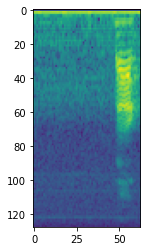

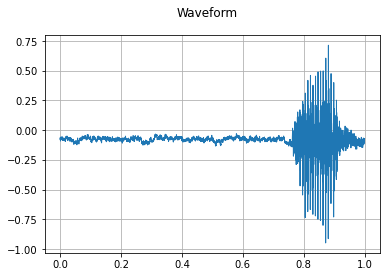

In [39]:

if __name__ == "__main__":

    args = get_args()
    args.device = torch.device('cuda' if args.cuda else 'cpu')
    if not os.path.exists(args.path):
        os.makedirs(args.path, exist_ok=True)

    model = KWSModel(args)
    datamodule = KWSDataModule(batch_size=args.batch_size, num_workers=args.num_workers,
                               path=args.path, n_fft=args.n_fft, n_mels=args.n_mels,
                               win_length=args.win_length, hop_length=args.hop_length)
    datamodule.setup()
    trainer = pl.Trainer()

    #trainer.fit(model=model, datamodule=datamodule)

    data, sample_rate, _, _, label = datamodule.train_dataset[0]
    print(data.max(), data.min(), data.mean())
    print(sample_rate)
    print(label)

    mel = datamodule.transform(data).squeeze(0)
    mel = librosa.power_to_db(mel.numpy())
    print(mel.shape, type(mel), mel.max(), mel.min())
    plt.imshow(mel)

    plot_waveform(data, sample_rate)


### KWS Model

In [ ]:

# load kws dataset
def load_kws_dataset(path, subset="training"):
    dataset = torchaudio.datasets.SPEECHCOMMANDS(path, 
                                                 download=True, 
                                                 subset=subset)
    return dataset
# create a kws dataloarder
def create_kws_dataloader(dataset, 
                          batch_size=1, 
                          shuffle=True, 
                          num_workers=0,
                          transform=None):

    dataloader = torch.utils.data.DataLoader(dataset, 
                                             batch_size=batch_size, 
                                             shuffle=shuffle, 
                                             num_workers=num_workers, 
                                             transform=transform)
    return dataloader


def train(model, dataloader, optimizer, criterion, device):
    model.train()
    for i, data in enumerate(dataloader):
        # get the inputs
        inputs, labels = data
        inputs = inputs.to(device)
        labels = labels.to(device)

        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        if (i+1) % 100 == 0:
            print(
                f'Epoch [{epoch+1}/{num_epochs}], Step [{i+1}/{len(dataloader)}], Loss: {loss.item():.4f}')

def validation_loop(model, dataloader, criterion, device):
    model.eval()
    with torch.no_grad():
        for i, data in enumerate(dataloader):
            # get the inputs
            inputs, labels = data
            inputs = inputs.to(device)
            labels = labels.to(device)

            # forward + backward + optimize
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            # compute accuracy
            _, predicted = torch.max(outputs.data, 1)
            total = labels.size(0)
            correct = (predicted == labels).sum().item()
            accuracy = correct / total

            if (i+1) % 100 == 0:
                print(f'Step [{i+1}/{len(dataloader)}], Loss: {loss.item():.4f}, Accuracy: {accuracy:.4f}')

    return accuracy



